/home/dairaku/py3env/lib/python3.11/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.DataArray (lat: 81, lon: 97)>
array([[ 91.75227751, 101.54691699, 112.08227806, ...,   1.65469419,
          2.18098489,   2.52658788],
       [  6.37531275,  13.99982193,  22.91509736, ...,   5.09456731,
          5.56644727,   5.36177822],
       [ 16.79816341,  15.10535913,  16.2667875 , ...,   3.34775359,
          4.61446871,   7.97081702],
       ...,
       [ 23.86755295,  40.57969636,  54.79949323, ...,  36.83366594,
         48.34994979,  48.88397598],
       [ 66.38288323,  78.27622903,  65.4680407 , ...,  44.73128502,
         38.51634392,  27.85909055],
       [ 22.97503306,  15.64820741,  18.55549817, ...,  77.3364518 ,
         55.29521513,  23.5560783 ]])
Coordinates:
  * lon        (lon) float32 70.0 71.25 72.5 73.75 ... 186.2 187.5 188.8 190.0
  * lat        (lat) float32 80.0 78.75 77.5 76.25 ... -16.25 -17.5 -18.75 -20.0
    time       datetime64[ns] 2006-07-19
    metpy_crs  object Projection: latitude_longitude


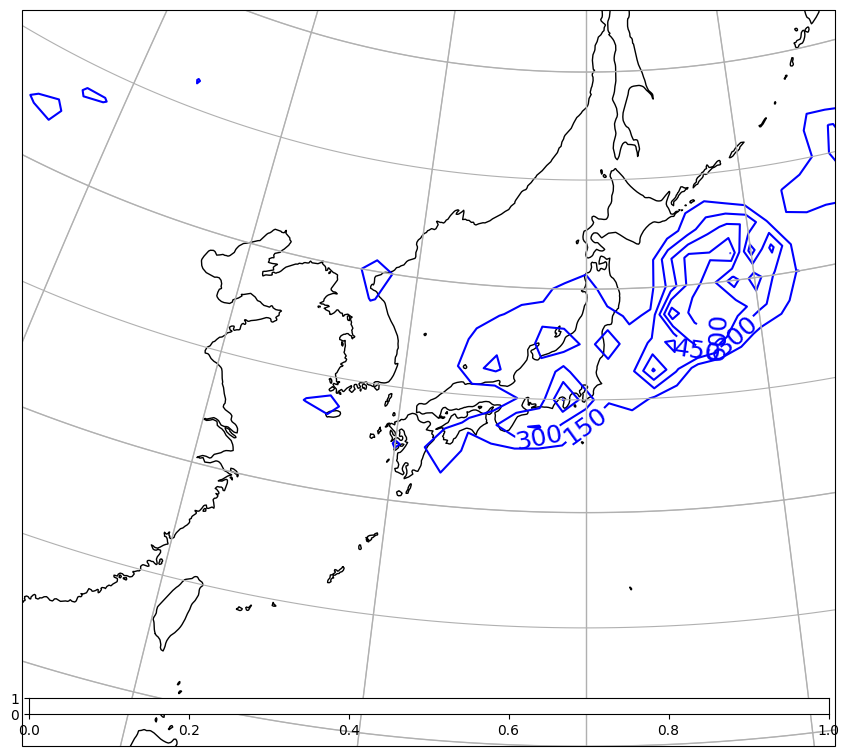

<xarray.DataArray (lat: 81, lon: 97)>
array([[ 91.75227751, 101.54691699, 112.08227806, ...,   1.65469419,
          2.18098489,   2.52658788],
       [  6.37531275,  13.99982193,  22.91509736, ...,   5.09456731,
          5.56644727,   5.36177822],
       [ 16.79816341,  15.10535913,  16.2667875 , ...,   3.34775359,
          4.61446871,   7.97081702],
       ...,
       [ 23.86755295,  40.57969636,  54.79949323, ...,  36.83366594,
         48.34994979,  48.88397598],
       [ 66.38288323,  78.27622903,  65.4680407 , ...,  44.73128502,
         38.51634392,  27.85909055],
       [ 22.97503306,  15.64820741,  18.55549817, ...,  77.3364518 ,
         55.29521513,  23.5560783 ]])
Coordinates:
  * lon        (lon) float32 70.0 71.25 72.5 73.75 ... 186.2 187.5 188.8 190.0
  * lat        (lat) float32 80.0 78.75 77.5 76.25 ... -16.25 -17.5 -18.75 -20.0
    time       datetime64[ns] 2006-07-19
    metpy_crs  object Projection: latitude_longitude


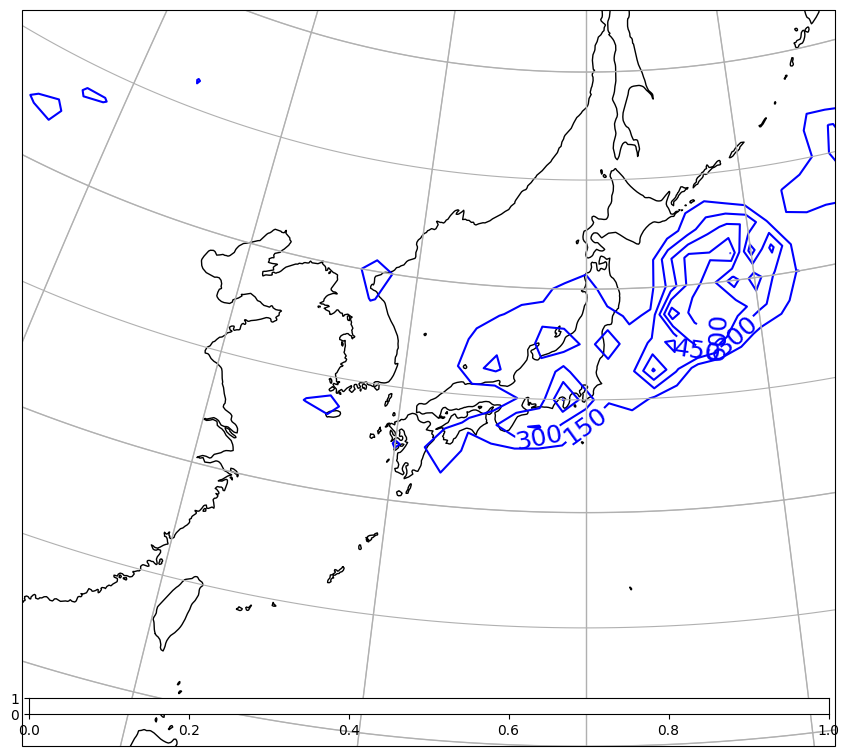

In [1]:
## JRA55 netcdf形式データの読み込み処理
import datetime
from dateutil import tz
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import metpy.calc as mpcalc
import metpy.constants as m_const
from metpy.units import units
import numpy as np
import xarray as xr
import scipy.ndimage as ndimage
import scipy.constants as s_const
import sys
import math
import pandas
import sympy
from mpl_toolkits.basemap import Basemap

## 読み込みデータの指定
# JRA55の読み込む年月日時をUTCで与えます。
i_year =2006
i_month = 7
i_day = 19
i_hourZ = 0
# データ切り出し領域
lat_cut=slice(80.0,-20.0)
lon_cut=slice(70.0,190.0)
level_cut=slice(300.0,1e+3)

# データ格納先フォルダー名
DataFd="./data/Jra55/"

## 描画指定
# 地図の描画範囲指定
i_area = [115, 151, 20, 50]  # 日本付近
# 緯線・経線の指定
dlon,dlat=10,10   # 10度ごとに

## データ読み込み、データセット作成
# time番号                                                                 
time_targ=(i_day - 1) * 4 + i_hourZ // 6
# 年月の6桁の整数(文字列)の取得                                      
yyyymm='{:04d}{:02d}'.format(i_year,i_month)

## 月別のNetCDF File名：複数のデータセットからデータを引き出して作成する
# 風速:東西成分
UgrdFn ='{}UGRD_{}.nc'.format(DataFd,yyyymm)
# 風速:南北成分
VgrdFn ='{}VGRD_{}.nc'.format(DataFd,yyyymm)
#高度
HgtFn ='{}HGT_{}.nc'.format(DataFd,yyyymm)
#比湿
Reld ='{}RELD_{}.nc'.format(DataFd,yyyymm)



## Wind U                                                                  
ds = xr.open_dataset(UgrdFn)
dataUgrd = ds.metpy.parse_cf('UGRD').squeeze()
# アクセス方法について
#print(dataUgrd)
## 時刻や座標などの次元の取得
#print(dataUgrd.dims)
## 次元ごとに、xarray形式の配列の長さを取得し、配列の最後の値を取り出す。
for dim in dataUgrd.dims:
    size = dataUgrd.sizes[dim]
#    print(dim,'   length:',size,'   last value:',dataUgrd[dim][size - 1].data)
#
dataUgrd.attrs['units'] = 'm/s'
# 利用するデータのみ切り出す                                               
dataUgrd = dataUgrd.isel(time=time_targ)
dataUgrd = dataUgrd.sel(level=level_cut,
                        lat=lat_cut,
                        lon=lon_cut)
## Wind V                                                                  
ds = xr.open_dataset(VgrdFn)
dataVgrd = ds.metpy.parse_cf('VGRD').squeeze()
dataVgrd.attrs['units'] = 'm/s'
dataVgrd = dataVgrd.isel(time=time_targ)
dataVgrd = dataVgrd.sel(level=level_cut,
                        lat=lat_cut,
                        lon=lon_cut)
## 高度                                                                    
ds = xr.open_dataset(HgtFn)
dataHgt = ds.metpy.parse_cf('HGT').squeeze()
dataHgt.attrs['units'] = 'meter'
dataHgt = dataHgt.isel(time=time_targ)
dataHgt = dataHgt.sel(lat=lat_cut,
                      lon=lon_cut)
## 比湿                                                                    
ds = xr.open_dataset(Reld)
dataReld = ds.metpy.parse_cf('RELD').squeeze()
dataReld = dataReld.isel(time=time_targ)
dataReld = dataReld.sel(lat=lat_cut,
                      lon=lon_cut)

### 計算
# 非地衡風 m/s => knot                                                     
#uag, vag = mpcalc.ageostrophic_wind(dataHgt, dataUgrd, dataVgrd)

dataRU = dataReld * dataUgrd
dataRV = dataReld * dataVgrd
#print(dataRU)
#y1 = dataRU
#dataRU2 = 
#axis=0 がlevelの列の総和
#print(np.sum(dataRU, axis=0))
dataRU2 = np.sum(dataRU, axis=0)
dataRV2 = np.sum(dataRV, axis=0)
dataRUg = dataRU2/9.8
dataRVg = dataRV2/9.8
#print(dataRUg)
IVT = np.sqrt(dataRUg*dataRUg + dataRVg*dataRVg)*1000000
print(IVT)

## 図法指定                                                                             
proj = ccrs.Stereographic(central_latitude=60, central_longitude=140)
latlon_proj = ccrs.PlateCarree()
## 図のSIZE指定inch                                                                        
fig = plt.figure(figsize=(10,8))
## 図に関する設定                                                          
plt.rcParams["contour.negative_linestyle"] = 'solid'
## 余白設定                                                                                
plt.subplots_adjust(left=0, right=1, bottom=0.06, top=0.98)                  
## 作図                                                                                    
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_extent(i_area, latlon_proj)
#
## 海岸線
ax.coastlines(resolution='50m',) # 海岸線の解像度を上げる                                                    
ax.gridlines()
#
## グリッド線                                                                                                 
xticks=np.arange(0,360.1,dlon)
yticks=np.arange(-90,90.1,dlat)
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)
gl.ylocator = mticker.FixedLocator(yticks)
#
# colorbarの位置と大きさ指定                                               
#  add_axes([左端の距離, 下端からの距離, 横幅, 縦幅])                      
ax_reld = fig.add_axes([0.1, 0.1, 0.8, 0.02])

## IVT等値線                                                                 
cn_IVT = ax.contour(IVT.lon, IVT.lat, IVT.values,
                    colors='blue', linewidths=1.5,levels=5,
                    transform=latlon_proj )
ax.clabel(cn_IVT, fontsize=18, inline=True, colors='blue',
          inline_spacing=5, fmt='%i', rightside_up=True)
### 図の説明
#fig.text(0.5,0.01,dt_str+" {0}hPa Hight, ISOTACH, Divergence, Ageostrophic wind".format(i_pre),
#         ha='center',va='bottom', size=18)
plt.show()
## plt.savefig("JapanMap.png")
quit()## JRA55 netcdf形式データの読み込み処理
import datetime
from dateutil import tz
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import metpy.calc as mpcalc
import metpy.constants as m_const
from metpy.units import units
import numpy as np
import xarray as xr
import scipy.ndimage as ndimage
import scipy.constants as s_const
import sys
import math
import pandas
import sympy
from mpl_toolkits.basemap import Basemap

## 読み込みデータの指定
# JRA55の読み込む年月日時をUTCで与えます。
i_year =2006
i_month = 7
i_day = 19
i_hourZ = 0
# データ切り出し領域
lat_cut=slice(80.0,-20.0)
lon_cut=slice(70.0,190.0)
level_cut=slice(300.0,1e+3)

# データ格納先フォルダー名
DataFd="./data/Jra55/"

## 描画指定
# 地図の描画範囲指定
i_area = [115, 151, 20, 50]  # 日本付近
# 緯線・経線の指定
dlon,dlat=10,10   # 10度ごとに

## データ読み込み、データセット作成
# time番号                                                                 
time_targ=(i_day - 1) * 4 + i_hourZ // 6
# 年月の6桁の整数(文字列)の取得                                      
yyyymm='{:04d}{:02d}'.format(i_year,i_month)

## 月別のNetCDF File名：複数のデータセットからデータを引き出して作成する
# 風速:東西成分
UgrdFn ='{}UGRD_{}.nc'.format(DataFd,yyyymm)
# 風速:南北成分
VgrdFn ='{}VGRD_{}.nc'.format(DataFd,yyyymm)
#高度
HgtFn ='{}HGT_{}.nc'.format(DataFd,yyyymm)
#比湿
Reld ='{}RELD_{}.nc'.format(DataFd,yyyymm)



## Wind U                                                                  
ds = xr.open_dataset(UgrdFn)
dataUgrd = ds.metpy.parse_cf('UGRD').squeeze()
# アクセス方法について
#print(dataUgrd)
## 時刻や座標などの次元の取得
#print(dataUgrd.dims)
## 次元ごとに、xarray形式の配列の長さを取得し、配列の最後の値を取り出す。
for dim in dataUgrd.dims:
    size = dataUgrd.sizes[dim]
#    print(dim,'   length:',size,'   last value:',dataUgrd[dim][size - 1].data)
#
dataUgrd.attrs['units'] = 'm/s'
# 利用するデータのみ切り出す                                               
dataUgrd = dataUgrd.isel(time=time_targ)
dataUgrd = dataUgrd.sel(level=level_cut,
                        lat=lat_cut,
                        lon=lon_cut)
## Wind V                                                                  
ds = xr.open_dataset(VgrdFn)
dataVgrd = ds.metpy.parse_cf('VGRD').squeeze()
dataVgrd.attrs['units'] = 'm/s'
dataVgrd = dataVgrd.isel(time=time_targ)
dataVgrd = dataVgrd.sel(level=level_cut,
                        lat=lat_cut,
                        lon=lon_cut)
## 高度                                                                    
ds = xr.open_dataset(HgtFn)
dataHgt = ds.metpy.parse_cf('HGT').squeeze()
dataHgt.attrs['units'] = 'meter'
dataHgt = dataHgt.isel(time=time_targ)
dataHgt = dataHgt.sel(lat=lat_cut,
                      lon=lon_cut)
## 比湿                                                                    
ds = xr.open_dataset(Reld)
dataReld = ds.metpy.parse_cf('RELD').squeeze()
dataReld = dataReld.isel(time=time_targ)
dataReld = dataReld.sel(lat=lat_cut,
                      lon=lon_cut)

### 計算
# 非地衡風 m/s => knot                                                     
#uag, vag = mpcalc.ageostrophic_wind(dataHgt, dataUgrd, dataVgrd)

dataRU = dataReld * dataUgrd
dataRV = dataReld * dataVgrd
#print(dataRU)
#y1 = dataRU
#dataRU2 = 
#axis=0 がlevelの列の総和
#print(np.sum(dataRU, axis=0))
dataRU2 = np.sum(dataRU, axis=0)
dataRV2 = np.sum(dataRV, axis=0)
dataRUg = dataRU2/9.8
dataRVg = dataRV2/9.8
#print(dataRUg)
IVT = np.sqrt(dataRUg*dataRUg + dataRVg*dataRVg)*1000000
print(IVT)

## 図法指定                                                                             
proj = ccrs.Stereographic(central_latitude=60, central_longitude=140)
latlon_proj = ccrs.PlateCarree()
## 図のSIZE指定inch                                                                        
fig = plt.figure(figsize=(10,8))
## 図に関する設定                                                          
plt.rcParams["contour.negative_linestyle"] = 'solid'
## 余白設定                                                                                
plt.subplots_adjust(left=0, right=1, bottom=0.06, top=0.98)                  
## 作図                                                                                    
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_extent(i_area, latlon_proj)
#
## 海岸線
ax.coastlines(resolution='50m',) # 海岸線の解像度を上げる                                                    
ax.gridlines()
#
## グリッド線                                                                                                 
xticks=np.arange(0,360.1,dlon)
yticks=np.arange(-90,90.1,dlat)
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)
gl.ylocator = mticker.FixedLocator(yticks)
#
# colorbarの位置と大きさ指定                                               
#  add_axes([左端の距離, 下端からの距離, 横幅, 縦幅])                      
ax_reld = fig.add_axes([0.1, 0.1, 0.8, 0.02])

## IVT等値線                                                                 
cn_IVT = ax.contour(IVT.lon, IVT.lat, IVT.values,
                    colors='blue', linewidths=1.5,levels=5,
                    transform=latlon_proj )
ax.clabel(cn_IVT, fontsize=18, inline=True, colors='blue',
          inline_spacing=5, fmt='%i', rightside_up=True)
### 図の説明
#fig.text(0.5,0.01,dt_str+" {0}hPa Hight, ISOTACH, Divergence, Ageostrophic wind".format(i_pre),
#         ha='center',va='bottom', size=18)
plt.show()
## plt.savefig("JapanMap.png")
quit()